# Student Info
- s3716853
- Matthew Eletva

<a name="table_of_contents"></a>
# Table of contents 
(Select tiles to move between sections)
1. [Data Reading and Initial Transformations](#init_read)
2. [Initial Analysis](#init_analysis)
3. [Evaluation Metric](#evaluation_metric)
4. [Data Splitting](#data_split)
5. [Approach One: Logistic Regression](#logistic_regression)
    1. [Ensuring Split Integrity](#logistic_regression_split)
    2. [Baseline Model](#logistic_regression_polynomial)
    3. [Feature Scaling](#logistic_regression_feature_scaling)
    4. [Analysis](#logistic_regression_analysis)
6. [Approach Two: Decision Tree](#tree)
    1. [Ensuring Split Integrity](#tree_integrity)
    1. [Hyper Parameter Tuning](#tree_param_tune)
    2. [Decision Tree Analysis](#tree_analysis)
    3. [Random Forrest](#forrest)
        1. [Attempt 1: Depth of 51](#forrest_1)
        2. [Attempt 2: Depth of 11](#forrest_2)
        3. [Attempt 3: Improving Upon Depth of 11](#forrest_3)
        4. [Attempt 4: Improving Upon Depth of 51](#forrest_4)
        5. [Attempt 5: Post Pruning](#forrest_5)
7. [Choosing my final algorithm](#final_algorithm)
    1. [Data Preparation](#final_data_prep)
    2. [Predicting Test Data](#final_prediction)

# Running Notebook Instructions
Before attempting to run the code in Approach One or Two you must run the code within:
- Data Reading and Initial Transformations
- Evaluation Metric
- Data Splitting
As the code here will prepare everything needed by the approaches

# Assignment Notes
- "Predict if a given patient (i.e. newborn child) will be discharged from the hospital within 3 days (class 0) or will stay in hospital beyond that - 4 days or more (class 1)”
- Binary Classification problem
    - Class 0 (3 Days)
    - Class 1 (4 or more days)

# Approaches to Take
- ~~Multivariate Linear Regression~~
    - Due to the tasks nature as a binary classification problem, this approach will not be necessary
- Multivariate logistic regression
- Decision Trees

<a name="init_read"></a>
# Data Reading and Initial Transformations 
[To Table of Contents](#table_of_contents)

In [209]:
#importing APIs that will be required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [129]:
#This function prepares the data that will be used in the algorithms
#is used for both test and train data
#data is the data as read from the csv
# target_present is a boolean that represents whether LengthOfStay column is present
def prepare_data_for_algorithm(data, target_present=False):
    
    if target_present:
        # modifying LengthOfStay to represent Class 0 (True) and class 1 (False)
        for i in data.index:
            if data.at[i, "LengthOfStay"] < 4:
                data.at[i, "LengthOfStay"] = 1
            else:
                data.at[i, "LengthOfStay"] = 0
                
    data = data.drop(columns=['ID', 'HealthServiceArea'])
    
    # APRSeverityOfIllnessCode is not included as it is an integer (1-4) and is an ordinal category
    category_attributes = ["Gender", "Race", "TypeOfAdmission", "CCSProcedureCode", "PaymentTypology", "EmergencyDepartmentIndicator"]
    for col in data.columns:
        if col in category_attributes:
            data[col] = data[col].astype('category')
    
    #Turning categorical entries into multiple true or false columns
    data = pd.get_dummies(data)
    
    # Train data has no instances of Trauma in TypeOfAdmission so need to add it for the train data to work on any algorithms trained using Train
    if not "TypeOfAdmission_Trauma" in data.columns:
        data.insert(18, "TypeOfAdmission_Trauma", 0)
        data["TypeOfAdmission_Trauma"] = data["TypeOfAdmission_Trauma"].astype("uint8")
    
    # Train data has no instances of Department of Corrections in PaymentTopology so need to add it for the train data to work on any algorithms trained using Train
    if not "PaymentTypology_Department of Corrections" in data.columns:
        data.insert(28, "PaymentTypology_Department of Corrections", 0)
        data["PaymentTypology_Department of Corrections"] = data["PaymentTypology_Department of Corrections"].astype("uint8")
    
    return data

In [202]:
train_data = pd.read_csv("train_data.csv")

In [203]:
train_data = prepare_data_for_algorithm(train_data, True)

In [76]:
pd.isna(train_data).sum()

APRSeverityOfIllnessCode                     0
BirthWeight                                  0
AverageCostInCounty                          0
AverageChargesInCounty                       0
AverageCostInFacility                        0
AverageChargesInFacility                     0
AverageIncomeInZipCode                       0
LengthOfStay                                 0
Gender_F                                     0
Gender_M                                     0
Gender_U                                     0
Race_Black/African American                  0
Race_Multi-racial                            0
Race_Other Race                              0
Race_White                                   0
TypeOfAdmission_Elective                     0
TypeOfAdmission_Emergency                    0
TypeOfAdmission_Newborn                      0
TypeOfAdmission_Trauma                       0
TypeOfAdmission_Urgent                       0
CCSProcedureCode_-1                          0
CCSProcedureC

In [77]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59966 entries, 0 to 59965
Data columns (total 39 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   APRSeverityOfIllnessCode                   59966 non-null  int64
 1   BirthWeight                                59966 non-null  int64
 2   AverageCostInCounty                        59966 non-null  int64
 3   AverageChargesInCounty                     59966 non-null  int64
 4   AverageCostInFacility                      59966 non-null  int64
 5   AverageChargesInFacility                   59966 non-null  int64
 6   AverageIncomeInZipCode                     59966 non-null  int64
 7   LengthOfStay                               59966 non-null  int64
 8   Gender_F                                   59966 non-null  uint8
 9   Gender_M                                   59966 non-null  uint8
 10  Gender_U                                   599

<a name="init_analysis"></a>
# Initial Analysis

[To Table of Contents](#table_of_contents)

In [192]:
original_data = pd.read_csv("train_data.csv")

In [216]:
#Defining some visualisation functions to be used later
def create_bar_graph_for_attributes(dataframe, x=4, y=5):
    plt.figure(figsize=(20,20))
    for i, col in enumerate(dataframe.columns):
        data_to_plot = 0
        if col == "LengthOfStay":
            data_to_plot = dataframe[col].astype("int")
        else:
            data_to_plot = dataframe[col]
        plt.subplot(x,y,i+1)
        plt.hist(data_to_plot, alpha=0.3, color='b', density=True)
        plt.title(col)
        plt.xticks(rotation="vertical")

def create_box_plot_for_attributes(dataframe):
    plt.figure(figsize=(20,20))
    colCount = 0
    for i, col in enumerate(dataframe.columns):
        if dataframe.dtypes[col] == 'int64':
            plt.subplot(4,5,colCount+1)
            plt.boxplot(dataframe[col])
            plt.title(col)
            colCount += 1
    plt.show()
def create_scatterplot_for_attributes(dataframe, y_column="LengthOfStay"):
    plt.figure(figsize=(20,20))

    for i, col in enumerate(dataframe.columns):
        plt.subplot(4,5,i+1)
        sns.scatterplot(data=dataframe, x=col, y=y_column)
    #     sns.regplot(x=col,y='LengthOfStay', data=dataframe)
        plt.title(col)


    plt.xticks(rotation='vertical')
    plt.show()

In [194]:
original_data.describe()

,ID,CCSProcedureCode,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
count,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000,59966.000000
mean,29983.500000,155.404229,1.254594,3336.298903,2372.806690,7979.126922,2396.414318,7958.472668,59.811143,2.538405
std,17310.837458,89.541978,0.546207,446.244475,639.755096,3220.291347,1248.501189,3859.294711,21.470170,1.171246
min,1.000000,-1.000000,1.000000,2500.000000,712.000000,1243.000000,457.000000,1120.000000,28.000000,1.000000
25%,14992.250000,115.000000,1.000000,3000.000000,2041.000000,4620.000000,1551.000000,4438.000000,45.000000,2.000000
50%,29983.500000,220.000000,1.000000,3300.000000,2533.000000,9227.000000,1967.000000,7945.000000,55.000000,2.000000
75%,44974.750000,228.000000,1.000000,3600.000000,2785.000000,10644.000000,2895.000000,11619.000000,74.000000,3.000000
max,59966.000000,231.000000,4.000000,7500.000000,3242.000000,11381.000000,8114.000000,18466.000000,115.000000,10.000000


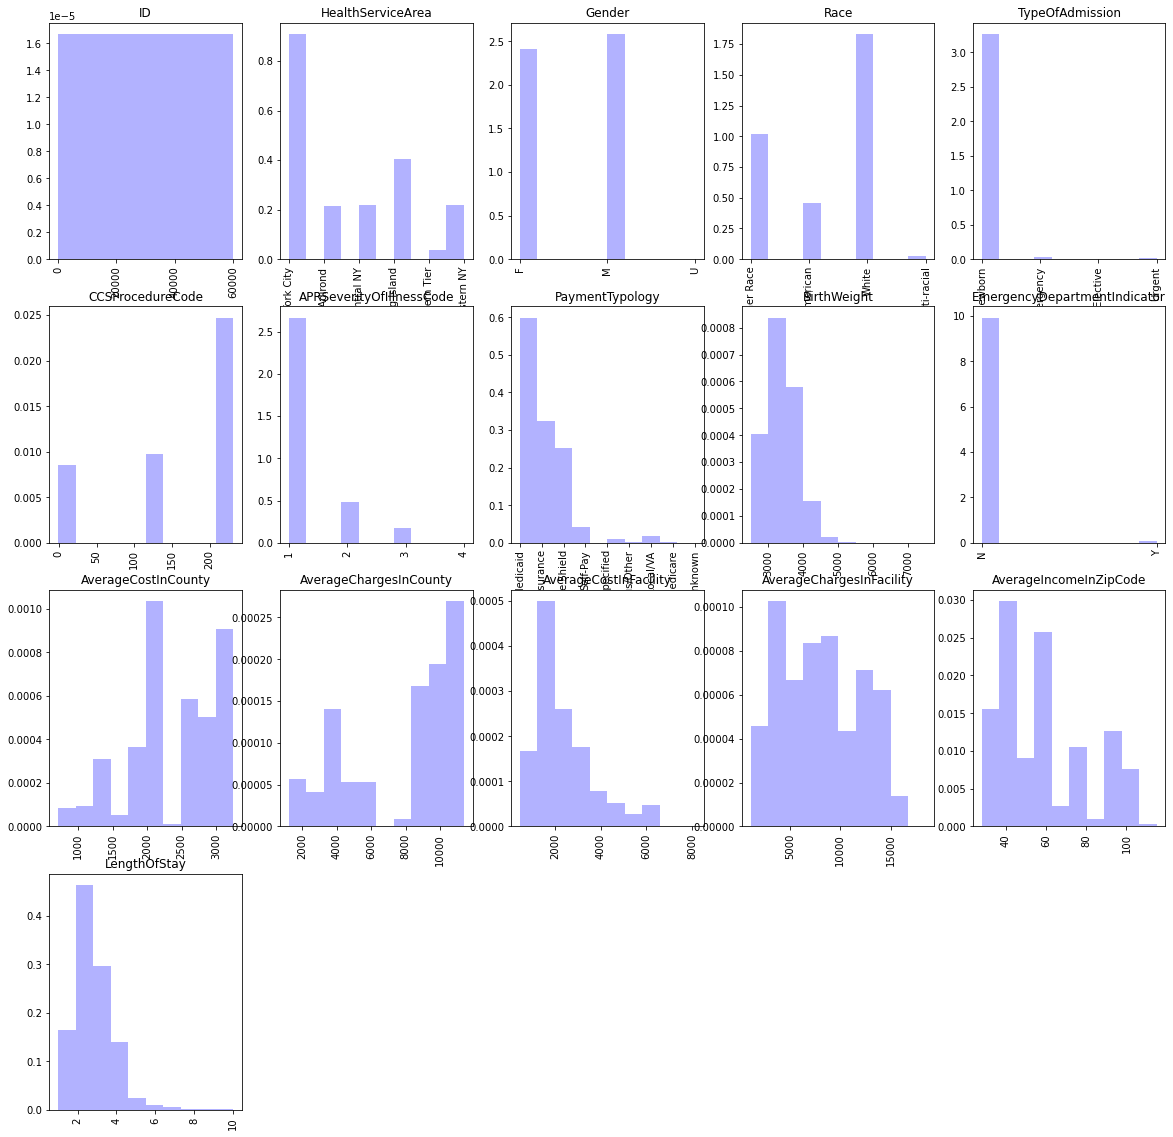

In [196]:
create_bar_graph_for_attributes(original_data)

#### Observations
- Gender
    - Few elements with Gender value of 'U'
        - Could cause issues for test data if 'U' is present there
- Race
    - 'White' is most common race by a large margin, followed by "Other Race". Probably won't be a great metric for the algorithm due to 'African American' and 'White' being the only specific ehtnicities.
        - Very few 'Multi Race' will probably lead to issues when predicting due to low data ammount to train on
        - African American will probably struggle for similar reasons as there are so few compared to White
- TypeOfAdmission
    - Vast majority of data has TypeOfAdmition as 'Newborn', other options have nearly none in comparison
        - Probabaly won't help with the algorithm all that much due to the heavy skew.
        - Could still have some effect (eg. Emergency could be more likely to be class 1).
- CCSProcedureCodes
    - Most CCSProcedureCodes are the one above 200, may be good to look into what they mean for your own analysis
- APRSeverityOfIllness 
    - Skews heavily towards 1 (Minor).
    - Few data points with value 4 (Extreme)
- PaymentTypology
    - Medicaid skew
- BirthWeight
    - Tend to be from 2500 - 4000
    - Heavy outlier (7500) present. 
- EmergencyDepartmentIndicator
    - Heavily skewed towards 'N'
- AverageCostInCounty
- AverageChargesInCounty
- AverageCostInFacility
    - Skews towards lower values
- AverageChargesInFacility
- AverageIncomeInZipCode
- LengthOfStay
    - Most cases are class 0 (lengthofstay<3)

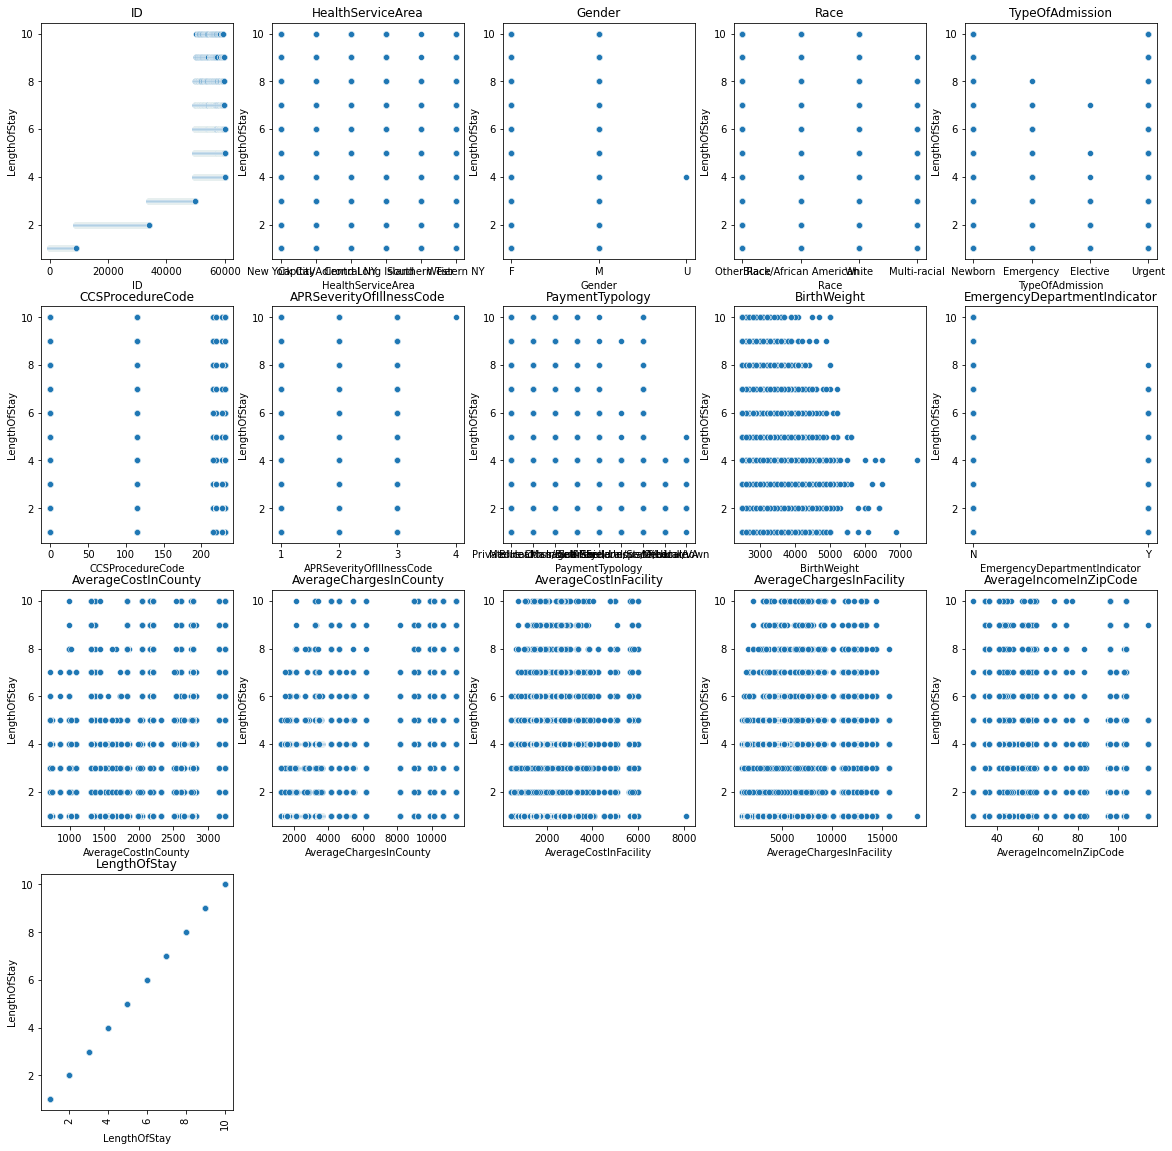

In [197]:
create_scatterplot_for_attributes(original_data)

### Observations

- No obvious relationship can be seen between LengthOfStay and any single variable.

- Not a single unknown gender patient that is class 0. ML Algorithm could pick up on this.

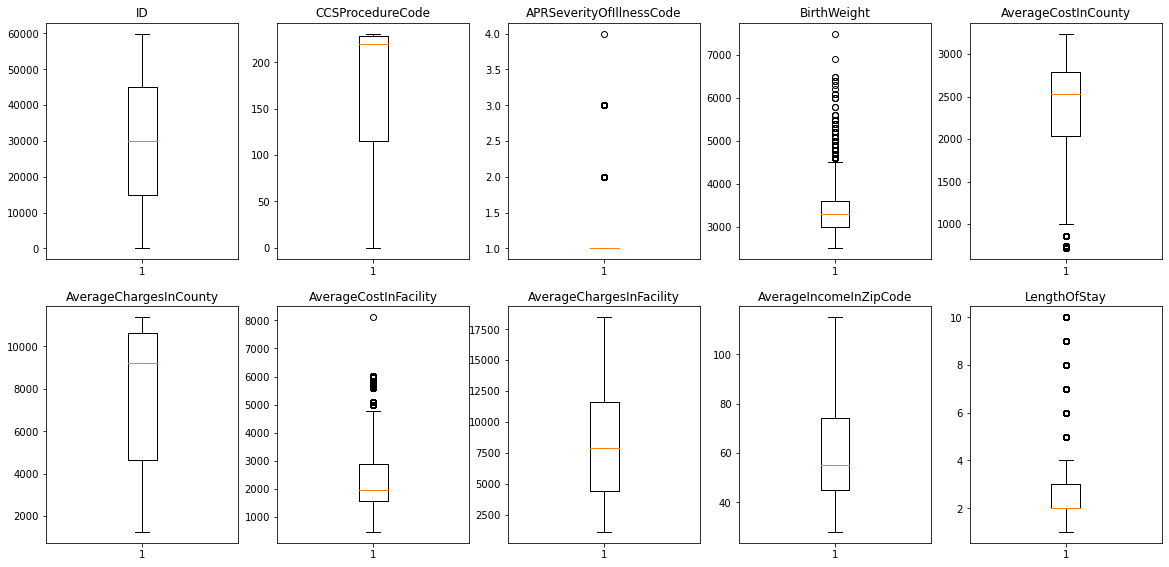

In [198]:
create_box_plot_for_attributes(original_data)

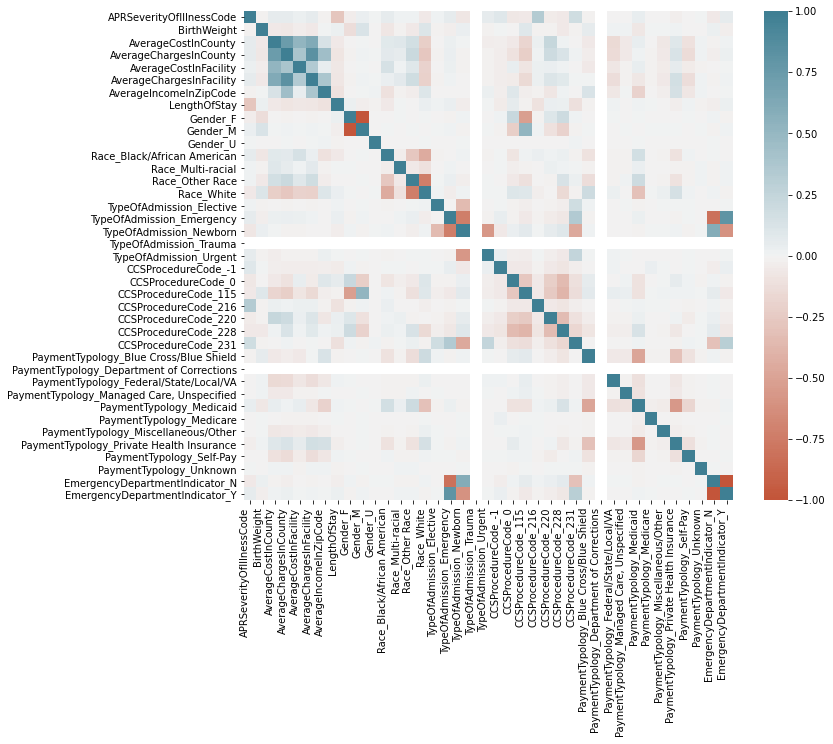

In [205]:
f, ax = plt.subplots(figsize=(11, 9))
corr = train_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

#### Notes on heatmap
- Attributes which correlate to LengthOfStay
    - APRSeverityOfIllness (negatively, also strongest correlation)
    - AverageCostInCounty (negatively)
    - AverageChargesInCounty (negatively)                  
    - AverageCostInFacility  (negatively)
    - AverageChargesInFacility (negatively)
    - AverageIncomeInZipCode (negatively)
    - CCSProcedureCode_231 (negatively)
    - CCSProcedureCode_226 (negatively)  
    - BirthWeight (Positive)

### Categorical Variables
- Ordinal
    - APRSeverityOfIllnessCode
- Nominal
    - Gender
    - Race
    - TypeOfAdmission
    - CCSProcedureCode
    - PaymentTypology
    - EmergencyDepartmentIndicator

#### Numerical Variables
- Continuous
    - BirthWeight
    - AverageCostInCounty
    - AverageChargesInCounty
    - AverageCostInFacility
    - AverageChargesInFacility
    - AverageIncomeInZipCode
- Discrete
    - NONE

<a name="evaluation_metric"></a>
# Deciding the Evaluation Metric 
[To Table of Contents](#table_of_contents)

As the purpose of this machine learning task is to help improve resource allocation at hospitals by predicting how long a patient will stay the most important metric would be to ensure that Class 1 (>3days) patients are not incorrectly categorised as Class 0 (<3Days) patients (false positive), as this will lead to that patient requiring more resources than anticipated. The inverse scenario of a Class 0 (<3days) patient being incorrectly predicted as a Class 1 (>3days) patient (false negative) is not as harmful as it will lead to the patient requiring less resources than predicted so those resources can simply be put towards other patients, however it will still lead to incorrect resource allocation for the hospital. 

Given this, I believe the most important metrics when analysing this problem would be precision and f1 score.

Precision is quite intuitive to understand and we want to ensure false positives are as low as possible.

F1 score is meant to create a balence bewteen precision and recall, and as recall measures how many of the positive instances the classifier gets correct it will help reduce false negatives, I believe it will be beneficial metric when we are worried about both false negatives and false positives.

Below is a diagram to make this more clear

<img src="https://i.imgur.com/aK5h1lU.png" width="50%">

In [16]:
def get_precision_score(clf, *args):
    
    results = []
    
    for prediction_data in args:
        prediction = clf.predict(prediction_data[0])
        precision = precision_score(prediction_data[1], prediction, average="macro")
        
        results.append(precision)
    return results

def get_f1_scores(clf, *args):
    
    #this is to deal with code that was written before this function rewrite
    if not isinstance(args[0], tuple):
        return get_f1_scores_old(clf, args[0], args[1], args[2], args[3])
    
    results = []
    
    for prediction_data in args:
        prediction = clf.predict(prediction_data[0])
        f1 = f1_score(prediction_data[1], prediction, average="macro")
        
        results.append(f1)
    
    return results

def get_f1_scores_old(clf, train_X, train_y, val_X, val_y):
    train_pred = clf.predict(train_X)
    val_pred = clf.predict(val_X)
    
    train_f1 = f1_score(train_y, train_pred, average='macro')
    val_f1 = f1_score(val_y, val_pred, average='macro')
    
    return train_f1, val_f1

def print_eval_metrics(clf, labels, *args):
    
    pecision_scores = get_precision_score(clf, *args)
    f1_scores = get_f1_scores(clf, *args)
    
    scores = [];
    
    for i in range(len(labels)):
        print("{} f1 Score: {:.3f}".format(labels[i], f1_scores[i]))
        print("{} Precision Score: {:.3f}".format(labels[i], pecision_scores[i]))
        scores.append((f1_scores[i], pecision_scores[i]))
    
    # Returns results in case scores are needed
    return scores
        

<a name="data_split"></a>
# Data Splitting 
[To Table of Contents](#table_of_contents)

- Using Hold-out validation, as large size of our dataset should help ensure that a good split is made.
- Will also be quicker than cross-validation, which will be important because our dataset is quite large.

In [17]:
def split_data(data):
    # Splitting data to get a test split to use on my final hypothesis
    with pd.option_context('mode.chained_assignment', None):
        train_split, test_split = train_test_split(data, test_size=0.2, 
                                                 shuffle=True,random_state=0)
    with pd.option_context('mode.chained_assignment', None):
        train_split, validate_split = train_test_split(train_split, test_size=0.25, 
                                                 shuffle=True,random_state=0)
    return train_split, test_split, validate_split

<a name="logistic_regression"></a>
# Approach One: Logistic Regression
[To Table of Contents](#table_of_contents)

In [213]:
train_data_train_split, train_data_test_split, train_data_validate_split = split_data(train_data)

In [214]:
train_data_train_split.info()
train_data_test_split.info()
train_data_validate_split.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35979 entries, 47077 to 39288
Data columns (total 39 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   APRSeverityOfIllnessCode                   35979 non-null  int64
 1   BirthWeight                                35979 non-null  int64
 2   AverageCostInCounty                        35979 non-null  int64
 3   AverageChargesInCounty                     35979 non-null  int64
 4   AverageCostInFacility                      35979 non-null  int64
 5   AverageChargesInFacility                   35979 non-null  int64
 6   AverageIncomeInZipCode                     35979 non-null  int64
 7   LengthOfStay                               35979 non-null  int64
 8   Gender_F                                   35979 non-null  uint8
 9   Gender_M                                   35979 non-null  uint8
 10  Gender_U                                  

<a name="logistic_regression_split"></a>
## Ensuring split has kept similar data shape 
[To Table of Contents](#table_of_contents)

- We want to enusre the random split kept each set similar in distribution

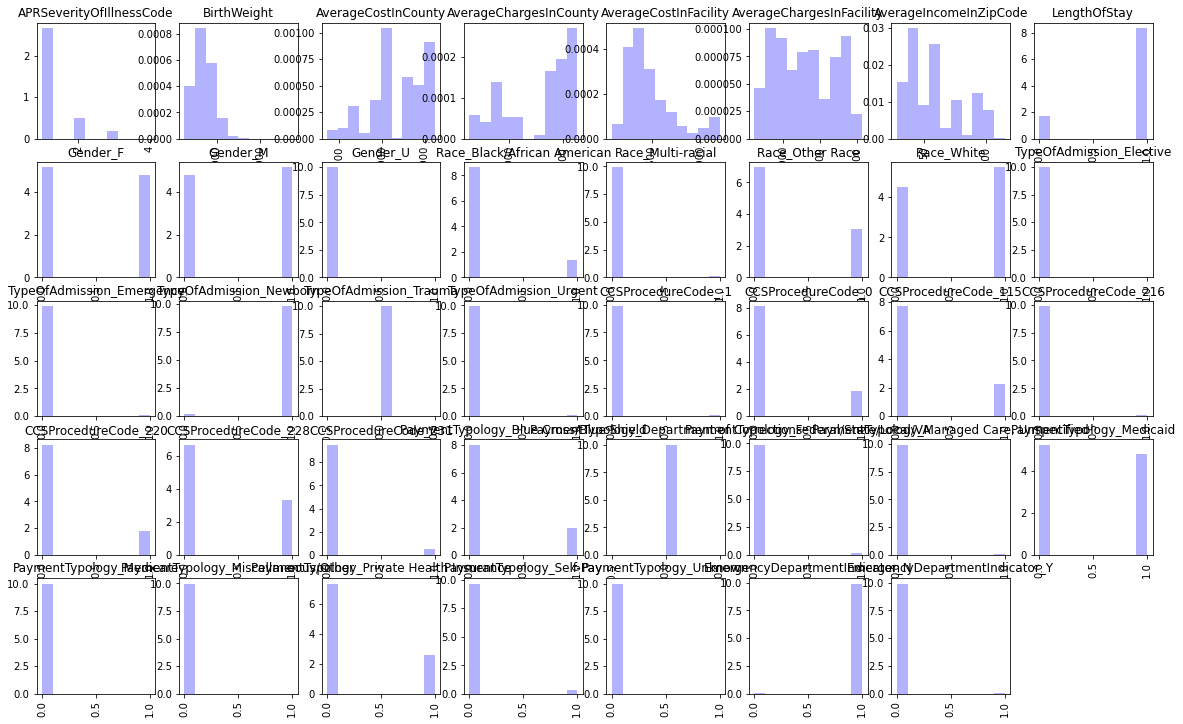

In [218]:
create_bar_graph_for_attributes(train_data_train_split, x=8, y=8)

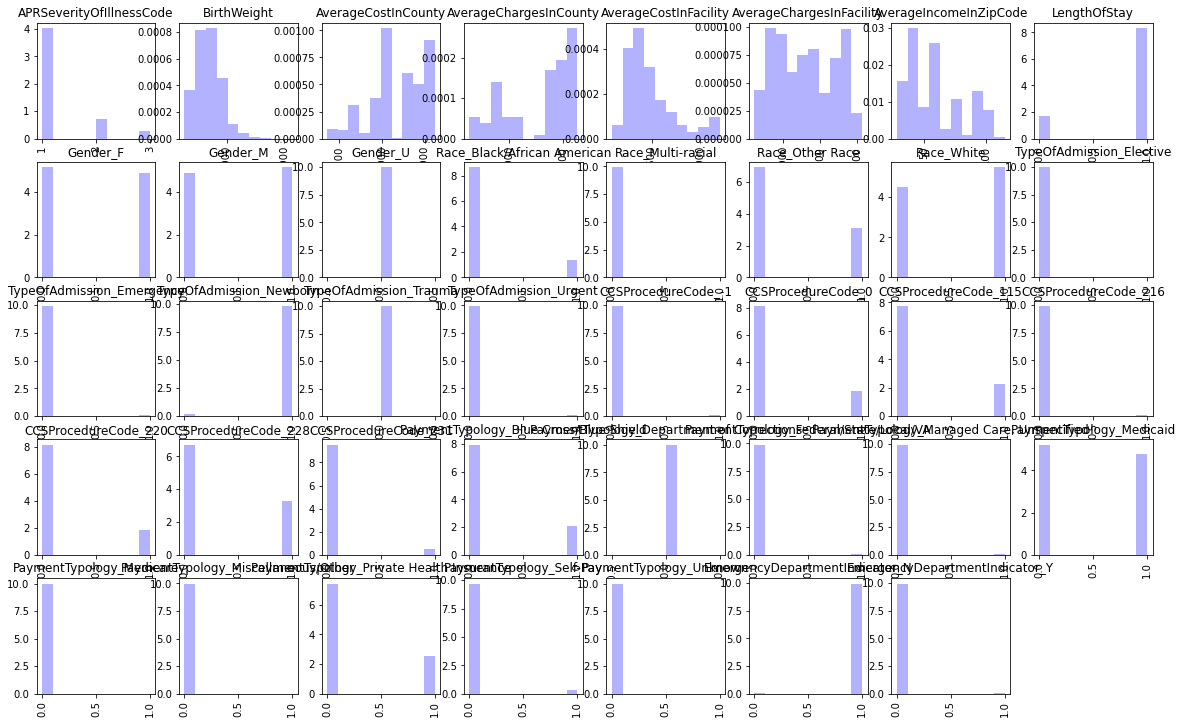

In [219]:
create_bar_graph_for_attributes(train_data_test_split, x=8, y=8)

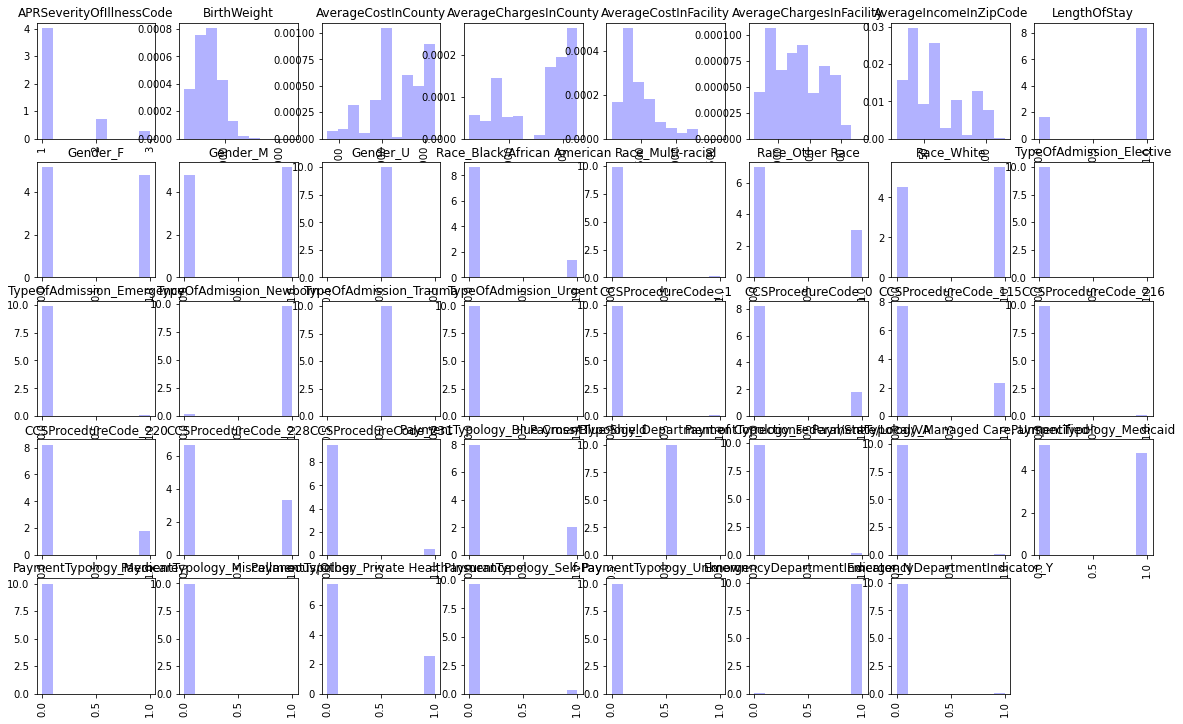

In [220]:
create_bar_graph_for_attributes(train_data_validate_split, x=8, y=8)

In [53]:
train_data_train_attributes = train_data_train_split.drop(['LengthOfStay',], axis=1).to_numpy()
train_data_train_target = train_data_train_split[['LengthOfStay']].to_numpy()

train_data_test_attributes = train_data_test_split.drop(['LengthOfStay',], axis=1).to_numpy()
train_data_test_target = train_data_test_split[['LengthOfStay']].to_numpy()

train_data_validate_attributes = train_data_validate_split.drop(['LengthOfStay',], axis=1).to_numpy()
train_data_validate_target = train_data_validate_split[['LengthOfStay']].to_numpy()

In [82]:
train_data_train_attributes.shape

(35979, 39)

In [55]:
train_data_test_attributes.shape

(11994, 39)

In [56]:
train_data_validate_attributes.shape

(11993, 39)

<a name="logistic_regression_polynomial"></a>
## Baseline Model
[To Table of Contents](#table_of_contents)

In [87]:
#%debug
poly = PolynomialFeatures(2)
poly.fit(train_data_train_attributes)

PolynomialFeatures()

In [88]:
poly.n_output_features_

820

In [89]:
poly.n_input_features_

39

In [91]:
train_data_train_attributes = poly.transform(train_data_train_attributes)
train_data_test_attributes = poly.transform(train_data_test_attributes)
train_data_validate_attributes = poly.transform(train_data_validate_attributes)

<a name="logistic_regression_feature_scaling"></a>
## Feature Scaling
[To Table of Contents](#table_of_contents)

- Given that many of the attributes are binary (such as the Gender attribute which was transformed into 3 boolean attributes for M, F and U) then I believe MinMax Scaling would be the way to go to ensure all attributes share the same range and thus should all be weighted evenly.

In [94]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_data_train_attributes)

train_data_train_attributes = min_max_scaler.transform(train_data_train_attributes)
train_data_test_attributes = min_max_scaler.transform(train_data_test_attributes)
train_data_validate_attributes = min_max_scaler.transform(train_data_validate_attributes)

In [95]:
clf = LogisticRegression(random_state=0, penalty='none', solver='saga', 
                         max_iter=1000, 
                         class_weight='balanced').fit(train_data_train_attributes, train_data_train_target.ravel())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [100]:
train_f1_score, validate_f1_score = get_f1_scores(clf, train_data_train_attributes, train_data_train_target, train_data_validate_attributes, train_data_validate_target)

In [101]:
print("Train F1-Score score: {:.3f}".format(train_f1_score))
print("Validation F1-Score score: {:.3f}".format(validate_f1_score))

Train F1-Score score: 0.623
Validation F1-Score score: 0.613


In [104]:
train_precision_score, validate_precision_score = get_precision_score(clf, (train_data_train_attributes, train_data_train_target), (train_data_validate_attributes, train_data_validate_target)

In [105]:
print("Train Precision score: {:.3f}".format(train_precision_score))
print("Validation Precison score: {:.3f}".format(validate_precision_score))

Train Precision score: 0.620
Validation Precison score: 0.610


<a name="logistic_regression_analysis"></a>
##  Logistic Regression Analysis
[To Table of Contents](#table_of_contents)

- Very small difference between training and validation
    - Good sign, means the algorithm has not over-fit to the training data
    - Regularisation not required in this case
- Actual score is quite low
    - Therefore the algorithm I have devised seems to be under-fitting
    - Solution to underfitting would be to increase the polynomial degree of my regression function
    
This approach is being abandoned due to issues with the PolynomialFeatures transform function.
train_data_train_attributes would have shape (35979, 39) and with a degree of 3, the transformed one has a shape of (35979, 11480) which has left me stumped as it shouldnt be increasing by such a large amount 

My design obviously has some issues as going above degree 2 causes errors due to the large size of the transformed attributes. Therefore improving my logisitic regression algorithm is impossible currently.



<a name="tree"></a>
# Approach Two: Decision Tree
[To Table of Contents](#table_of_contents)

## Data Preparation

In [132]:
decision_tree_train_data = train_data

In [9]:
# for i in train_data.index:
#     train_data.at[i, "LengthOfStay"]
#     if train_data.at[i, "LengthOfStay"] < 4:
#         train_data.at[i, "LengthOfStay"] = 1
#     else:
#         train_data.at[i, "LengthOfStay"] = 0

In [133]:
decision_tree_train_data["LengthOfStay"] = decision_tree_train_data["LengthOfStay"].astype("category")

In [134]:
decision_tree_train_data.head()

,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay,Gender_F,Gender_M,...,PaymentTypology_Federal/State/Local/VA,"PaymentTypology_Managed Care, Unspecified",PaymentTypology_Medicaid,PaymentTypology_Medicare,PaymentTypology_Miscellaneous/Other,PaymentTypology_Private Health Insurance,PaymentTypology_Self-Pay,PaymentTypology_Unknown,EmergencyDepartmentIndicator_N,EmergencyDepartmentIndicator_Y
0,1,3700,2611,9227,1751,8951,45,1,1,0,...,0,0,1,0,0,0,0,0,1,0
1,1,2900,3242,8966,3338,6409,34,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,3200,3155,11381,4980,9323,45,1,0,1,...,0,0,0,0,0,1,0,0,1,0
3,1,3300,3155,11381,5826,15680,59,1,1,0,...,0,0,0,0,0,1,0,0,1,0
4,1,2600,2611,9227,6000,14344,59,1,1,0,...,0,0,1,0,0,0,0,0,1,0


In [135]:
decision_tree_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59966 entries, 0 to 59965
Data columns (total 39 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   APRSeverityOfIllnessCode                   59966 non-null  int64   
 1   BirthWeight                                59966 non-null  int64   
 2   AverageCostInCounty                        59966 non-null  int64   
 3   AverageChargesInCounty                     59966 non-null  int64   
 4   AverageCostInFacility                      59966 non-null  int64   
 5   AverageChargesInFacility                   59966 non-null  int64   
 6   AverageIncomeInZipCode                     59966 non-null  int64   
 7   LengthOfStay                               59966 non-null  category
 8   Gender_F                                   59966 non-null  uint8   
 9   Gender_M                                   59966 non-null  uint8   
 10  Gender_U  

In [136]:
train_split, test_split, validate_split = split_data(decision_tree_train_data)

In [137]:
print(train_split.shape[0], test_split.shape[0], validate_split.shape[0])

35979 11994 11993


<a name="tree_integrity"></a>
## Ensuring Split Integrity
[To Table of Contents](#table_of_contents)

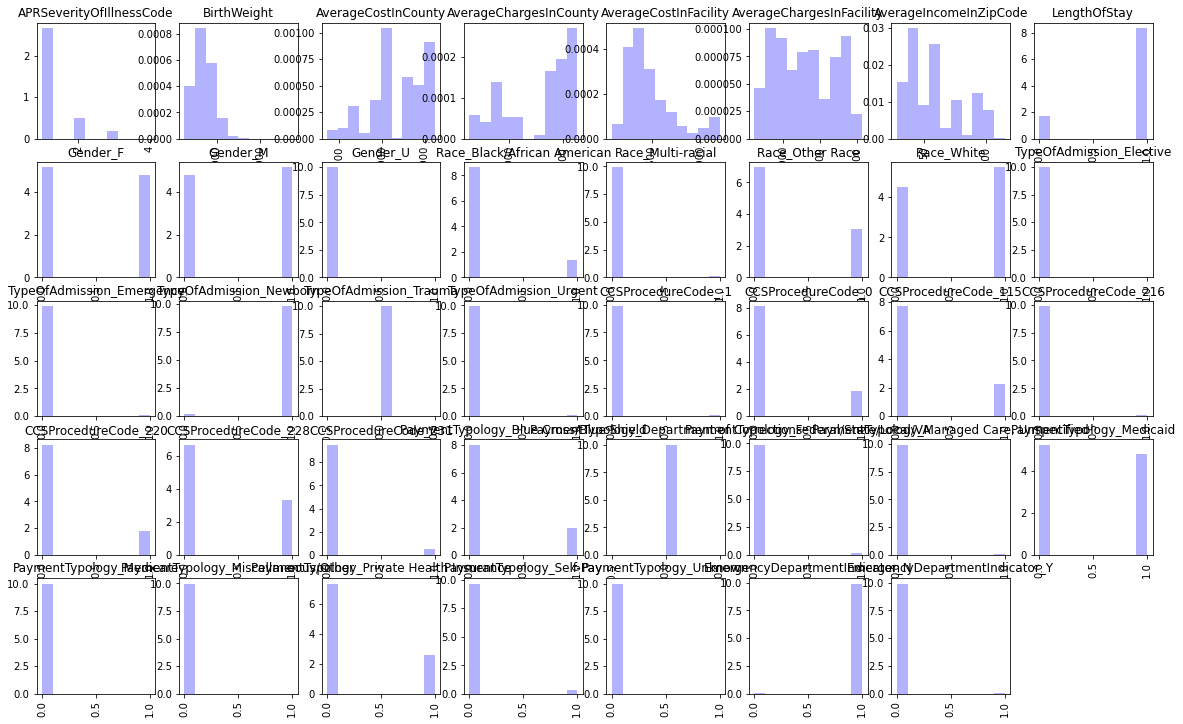

In [221]:
create_bar_graph_for_attributes(train_split, x=8, y=8)

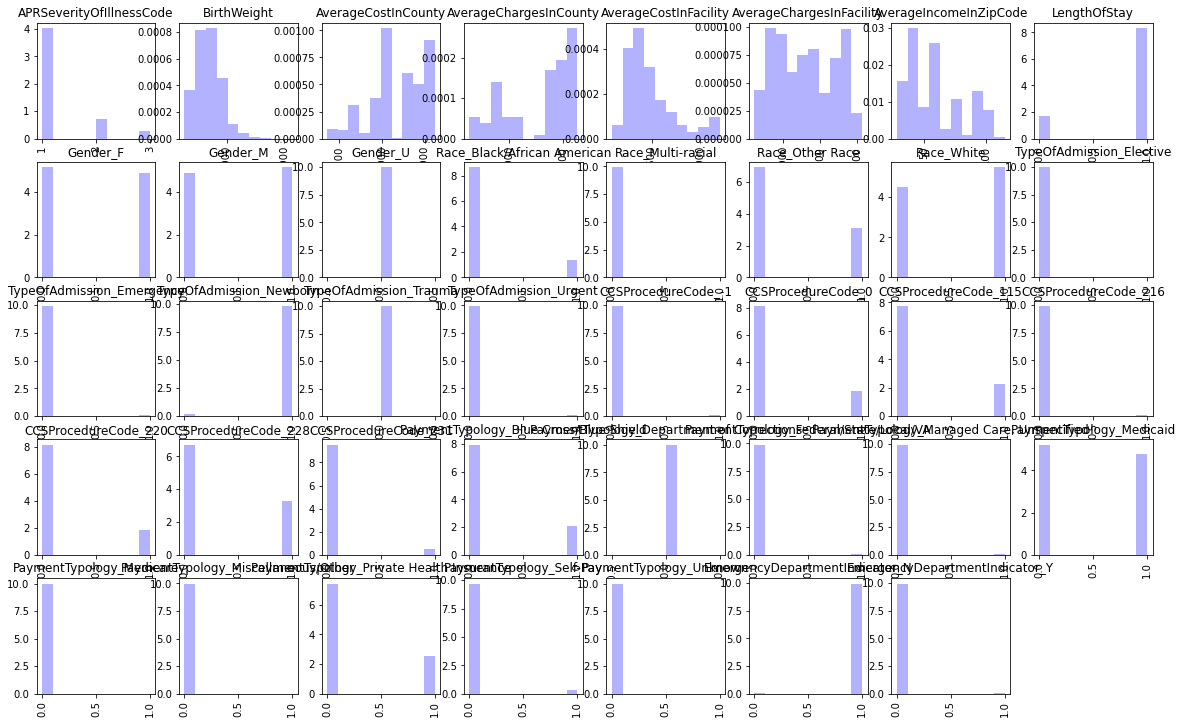

In [222]:
create_bar_graph_for_attributes(test_split, x=8, y=8)

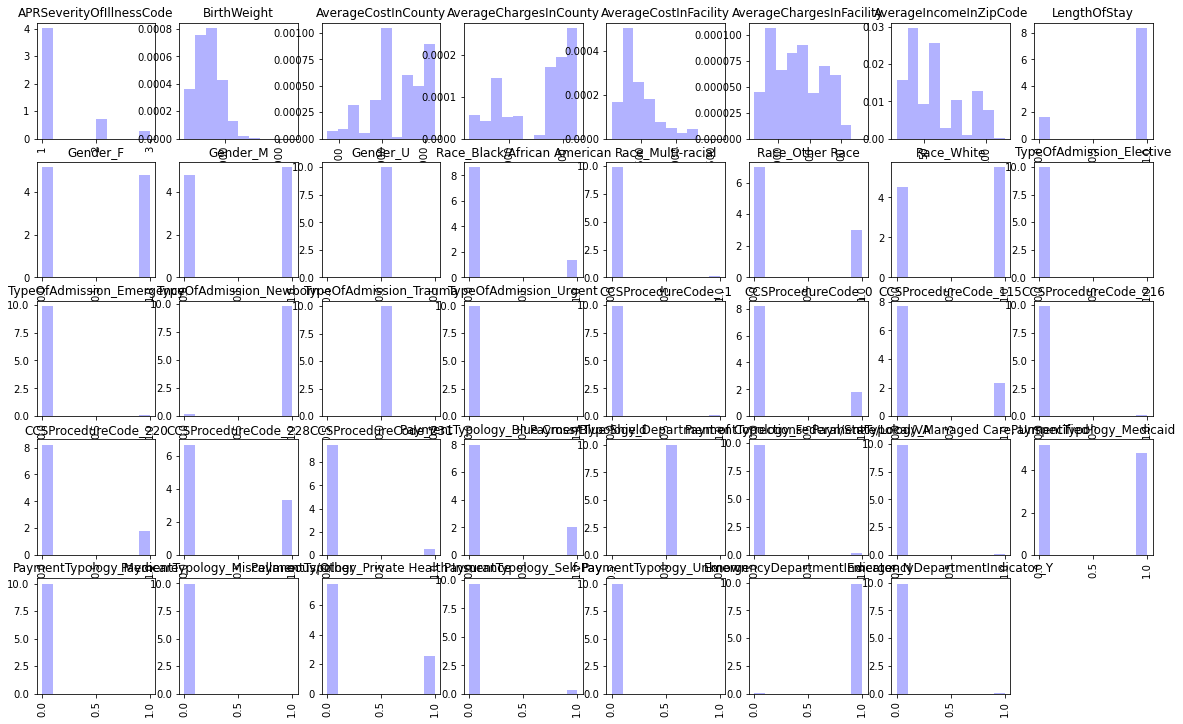

In [223]:
create_bar_graph_for_attributes(validate_split, x=8, y=8)

In [224]:
#Splitting target (LengthOfStay) away from attributes
train_split_target = train_split["LengthOfStay"].to_numpy()
train_split_attributes = train_split.drop(columns="LengthOfStay", axis=1).to_numpy()

test_split_target = test_split["LengthOfStay"].to_numpy()
test_split_attributes = test_split.drop(columns="LengthOfStay", axis=1).to_numpy()

validate_split_target = validate_split["LengthOfStay"].to_numpy()
validate_split_attributes = validate_split.drop(columns="LengthOfStay", axis=1).to_numpy()

## Initial Tree

In [28]:
tree_max_depth = 5
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=tree_max_depth, class_weight='balanced')
clf = clf.fit(train_split_attributes, train_split_target)

In [29]:
print_eval_metrics(clf, ("Train", "Validation"), (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

Train f1 Score: 0.628
Train Precision Score: 0.622
Validation f1 Score: 0.623
Validation Precision Score: 0.617


[(0.6282034001644332, 0.6218561971304379),
 (0.6231059338356442, 0.616673022680175)]

<a name="tree_param_tune"></a>
## Hyper Parameter Tuning
[To Table of Contents](#table_of_contents)

- In the above example, 5 was chosen as an initial attempt for max tree depth
- To ensure the best value for max tree depth is found, we must test multiple values and attempt to find the best
    - Want to ensure neither over fitting nor under fitting
- I have opted for GridSearch as we only have a single hyperparameter here (max depth of tree) so the lower performance when compared to Random search shouldnt cause the tuning to take too long

In [41]:
# This method is used to graph the performance of different hyper parameters
# results variable is retrieved from the cv_results attribute of the GridSearch
# fieldx is a string of the key in results to graph to the x axis
# fieldy is a string of the key in results to graph to the y axis
def graph_max_depth_values(results, fieldx, fieldy):
    
    dictionary = {
        fieldx: results[fieldx], 
        fieldy: results[fieldy]
    }
    
    plt.figure(figsize=(10,10))
    sns.scatterplot(data=pd.DataFrame(data=dictionary), x=fieldx, y=fieldy)
    
    plt.xticks(rotation='vertical')
    plt.show()

In [62]:
start = 1
end = 1000
step = 50
max_depth_values = np.arange(start, end, step)

dt_clf = tree.DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
Gridclf = GridSearchCV(dt_clf, {"max_depth": max_depth_values}, scoring='f1_macro')
Gridclf.fit(validate_split_attributes, validate_split_target)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='entropy'),
             param_grid={'max_depth': array([  1,  51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601,
       651, 701, 751, 801, 851, 901, 951])},
             scoring='f1_macro')

In [64]:
print(Gridclf.best_score_)
print(Gridclf.best_params_)

0.6141317209812096
{'max_depth': 1}


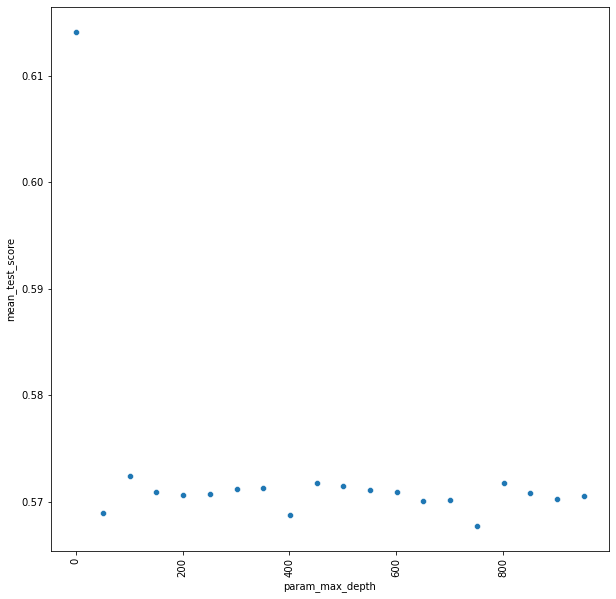

In [65]:
graph_max_depth_values(Gridclf.cv_results_, "param_max_depth", "mean_test_score")

With max depth of 1 being found by the above attempt, and because of the large difference bewteen step 1 (1) and step 2 (51) shown in the graph, lets try and see if a better max depth can be found on the lower end of the scale with a smaller step

In [54]:
start = 1
end = 100
step = 5
max_depth_values = np.arange(start, end, step)

dt_clf = tree.DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
Gridclf = GridSearchCV(dt_clf, {"max_depth": max_depth_values}, scoring='f1_macro')
Gridclf.fit(validate_split_attributes, validate_split_target)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='entropy'),
             param_grid={'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
             scoring='f1_macro')

In [55]:
print(Gridclf.best_score_)
print(Gridclf.best_params_)

0.6141317209812096
{'max_depth': 1}


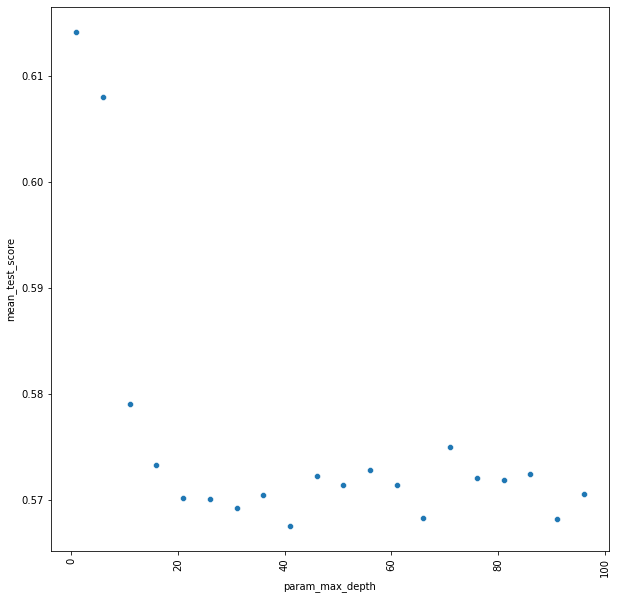

In [56]:
graph_max_depth_values(Gridclf.cv_results_, "param_max_depth", "mean_test_score")

Attempting steps near 1 to see if a better max depth of skipped over due to the step size

In [57]:
start = 1
end = 20
step = 1
max_depth_values = np.arange(start, end, step)

dt_clf = tree.DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
Gridclf = GridSearchCV(dt_clf, {"max_depth": max_depth_values}, scoring='f1_macro')
Gridclf.fit(validate_split_attributes, validate_split_target)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='entropy'),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='f1_macro')

In [58]:
print(Gridclf.best_score_)
print(Gridclf.best_params_)

0.6141317209812096
{'max_depth': 1}


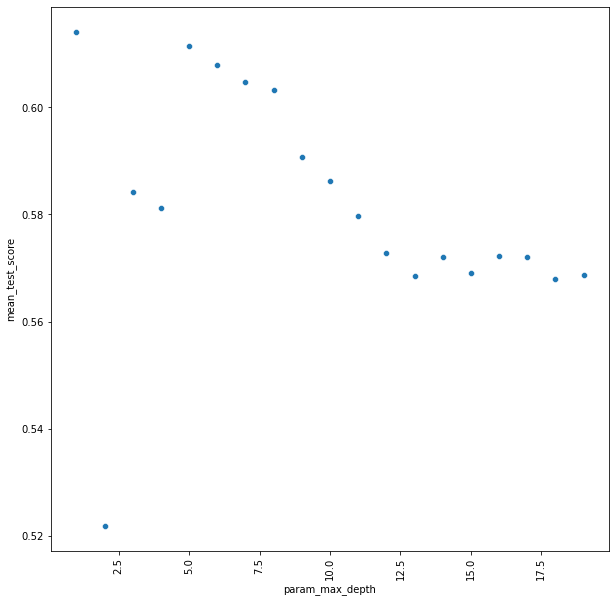

In [59]:
graph_max_depth_values(Gridclf.cv_results_, "param_max_depth", "mean_test_score")

<a name="tree_analysis"></a>
## Decision Tree Analysis
[To Table of Contents](#table_of_contents)

My decision tree post hyper parameter tuning has a max depth of 1, which for a data set so complex I don't believe would be very effective, and the results show just that. 

Changing the step size and searching for a different max depth may be beneficial, however attempts to find a better one so far have not been fruitful so I feel it may be best to instead look into a random forrest, so I believe it would be better to attempt a forrest as by mixing multiple decision trees they can improve an algorithms performance. 

<a name="forrest"></a>
## Random Forrest
[To Table of Contents](#table_of_contents)

<a name="forrest_1"></a>
### Random Forrest Attempt 1
[To Table of Contents](#table_of_contents)

#### Max Depth Hyper Parameter

In [66]:
start = 1
end = 1000
step = 50
max_depth_values = np.arange(start, end, step)

forrest_clf = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', random_state=0)

Gridclf = GridSearchCV(forrest_clf, {"max_depth": max_depth_values}, scoring='f1_macro')
Gridclf.fit(validate_split_attributes, validate_split_target)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              n_estimators=500,
                                              random_state=0),
             param_grid={'max_depth': array([  1,  51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601,
       651, 701, 751, 801, 851, 901, 951])},
             scoring='f1_macro')

In [67]:
Gridclf.best_params_

{'max_depth': 51}

In [70]:
print_eval_metrics(Gridclf.best_estimator_, ("Train", "Validate"), (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

Train f1 Score: 0.586
Train Precision Score: 0.615
Validate f1 Score: 0.960
Validate Precision Score: 0.944


[(0.5861339635109961, 0.6148431807652224),
 (0.9598656226169519, 0.9439542534403831)]

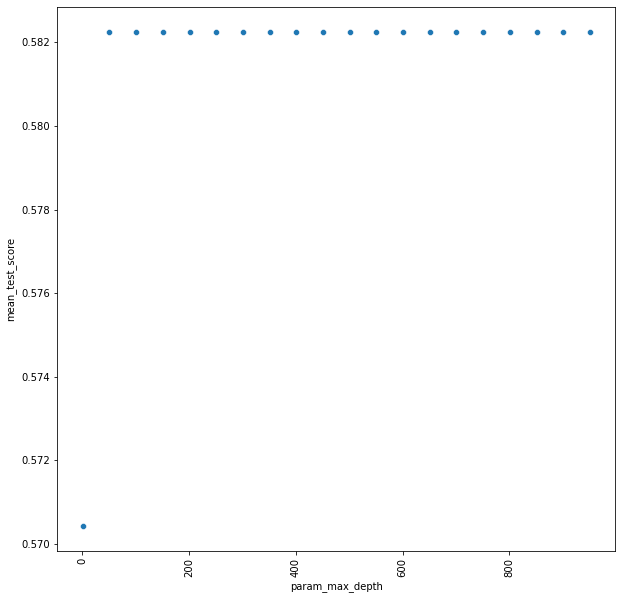

In [73]:
graph_max_depth_values(Gridclf.cv_results_, "param_max_depth", "mean_test_score")

#### Notes on hyper-parameter tuning
From the graph it can be seen that most max depths share similar mean scores, perhaps a better max depth can be found bewteen the steps

With the above hyper-parameter tuning my algorithm improved somewhat for the validation, so I decided to see how the the max depth of 51 would go in a random forrest fit to the training split.

In [35]:
forrest_clf = RandomForestClassifier(max_depth=51, n_estimators=500, class_weight='balanced_subsample', random_state=0)
forrest_clf.fit(train_split_attributes, train_split_target)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=51,
                       n_estimators=500, random_state=0)

In [40]:
forrest_train_f1_score, forrest_validate_f1_score = get_f1_scores(forrest_clf, train_split_attributes, train_split_target, validate_split_attributes, validate_split_target)
forrest_train_precision_score, forrest_validate_precision_score = get_precision_score(forrest_clf, (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

In [41]:
print("Train f1 score: {:.3f}".format(forrest_train_f1_score))
print("Validation f1 score: {:.3f}".format(forrest_validate_f1_score))
print("Train precison score: {:.3f}".format(forrest_train_precision_score))
print("Validation precison score: {:.3f}".format(forrest_validate_precision_score))

Train f1 score: 0.916
Validation f1 score: 0.591
Train precison score: 0.894
Validation precison score: 0.599


#### Notes on using 51 as max depth
Score improved, however now it seems to have overfit. Validation score went down and there is now a large gap bewteen the two

Post pruning of the tree could improve it by reducing how much it has overfit to the training data. 

For now however, I want to see if another max depth could be used instead.

<a name="forrest_2"></a>
### Random Forrest Attempt 2
[To Table of Contents](#table_of_contents)

- With 51 chosen as the max depth by the previous search, I felt a more precise search through the numbers around 50 would be good in case my step size missed the best max tree depth

#### Searching for different hyper parameter

In [50]:
start = 1
end = 100
step = 5
max_depth_values = np.arange(start, end, step)

forrest_clf2 = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', random_state=0)

Gridclf2 = GridSearchCV(forrest_clf2, {"max_depth": max_depth_values}, scoring='f1_macro')
Gridclf2.fit(validate_split_attributes, validate_split_target)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              n_estimators=500,
                                              random_state=0),
             param_grid={'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
             scoring='f1_macro')

In [76]:
Gridclf2.best_params_

{'max_depth': 11}

In [77]:
print_eval_metrics(Gridclf2.best_estimator_, ("Train", "Validate"), (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

Train f1 Score: 0.645
Train Precision Score: 0.632
Validate f1 Score: 0.731
Validate Precision Score: 0.708


[(0.6449141140992782, 0.6322357089058112),
 (0.7309771238800452, 0.708102474393049)]

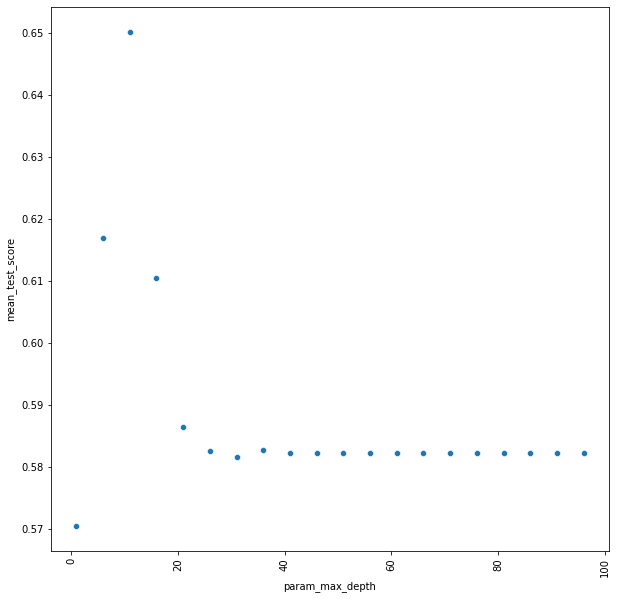

In [78]:
graph_max_depth_values(Gridclf2.cv_results_, "param_max_depth", "mean_test_score")

#### Notes on new max depth hyper paramter
- This time, 11 was found to be the best value for the max depth paramter
- My scores in different trees have turned out quite similar
    - Both max depth of 11 and 51 have the same Precisions and F1 Scores when a random forrest is fit to validation
- From the graph it can be see that depth 1-20 has the most varience, a better max depth could be within that range but was missed so further parameter tuning will be done later

#### Random Forrest Using Max Depth of 11

- I will now attempt the depth of 11 on a random forrest fit to the training data to see how it manages compared to 51
    - Following the principle of occam's razor, the more simple tree would be preferred, but we should first test it

In [139]:
forrest_clf_3 = RandomForestClassifier(max_depth=11, n_estimators=500, class_weight='balanced_subsample', random_state=0)
forrest_clf_3.fit(train_split_attributes, train_split_target)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=11,
                       n_estimators=500, random_state=0)

In [106]:
test_attr = train_split.drop(columns=["PaymentTypology_Department of Corrections", "TypeOfAdmission_Trauma", 'LengthOfStay']).to_numpy()

forrest_clf_3 = RandomForestClassifier(max_depth=11, n_estimators=500, class_weight='balanced_subsample', random_state=0)
forrest_clf_3.fit(test_attr, train_split_target)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=11,
                       n_estimators=500, random_state=0)

In [100]:
#train_split.drop(columns=["PaymentTypology_Department of Corrections", "TypeOfAdmission_Trauma", 'LengthOfStay']).info()

In [107]:
print_eval_metrics(forrest_clf_3, ("Train"), (test_attr, train_split_target))

T f1 Score: 0.398
T Precision Score: 0.338


IndexError: list index out of range

In [140]:
print_eval_metrics(forrest_clf_3, ("Train", "Validate"), (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

Train f1 Score: 0.672
Train Precision Score: 0.658
Validate f1 Score: 0.636
Validate Precision Score: 0.626


[(0.6722401027245795, 0.6579439281145067),
 (0.6359729204321843, 0.6264961769680957)]

#### Notes on Max depth of 11
Reducing the complexity of the tree has helped reduce the overfitting to the training data as seen in attempt 1, however my scores have not improved much and are still much lower than I would want.


<a name="forrest_3"></a>
### Random Forrest Attempt 3
[To Table of Contents](#table_of_contents)

#### Searching nearby max depth options

- this test is me trying to see if there are any values closer to 11 that could be better that were skipped by the previous step size
- the steps were as follows when 11 was found: [6, 11, 16]
    - So I will search just before 6 and just after 16 to see if they trend down but where skipped by the step sizes

In [79]:
start = 5
end = 17
step = 1
max_depth_values = np.arange(start, end, step)

forrest_clf_4 = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', random_state=0)

Gridclf_4 = GridSearchCV(forrest_clf_4, {"max_depth": max_depth_values}, scoring='f1_macro')
Gridclf_4.fit(validate_split_attributes, validate_split_target)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              n_estimators=500,
                                              random_state=0),
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])},
             scoring='f1_macro')

In [80]:
Gridclf_4.best_params_

{'max_depth': 11}

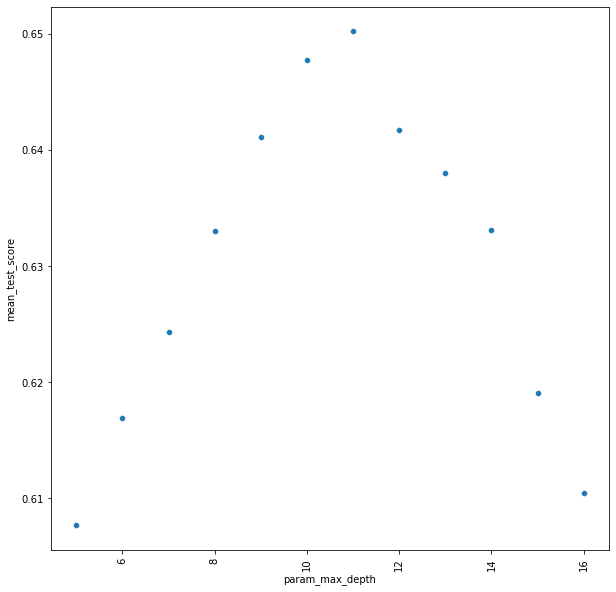

In [81]:
graph_max_depth_values(Gridclf_4.cv_results_, "param_max_depth", "mean_test_score")

#### Notes on searching nearby 11
- Grown more confidant with max depth of 11 now as it was chosen once again
- Nearby values do not improve, making me believe 11 is at least a local minima if this were to be graphed

### Increasing Random Tree Estimators
- Since 11 seems to be a good max depth, I will try increasing how many trees are used in this forrest to see if it helps improve my algorithms predictions

In [37]:
estimator_increase_clf = RandomForestClassifier(max_depth=11, n_estimators=750, class_weight='balanced_subsample', random_state=0)
estimator_increase_clf.fit(train_split_attributes, train_split_target)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=11,
                       n_estimators=750, random_state=0)

In [38]:
print_eval_metrics(estimator_increase_clf, ("Train", "Validate"), (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

Train f1 Score: 0.673
Train Precision Score: 0.659
Validate f1 Score: 0.638
Validate Precision Score: 0.628


#### Notes on Increasing Estimators to 750
- Only minor change in scores
- Further estimator increases will be attempted to see if a larger number will do much

In [41]:
estimator_increase_clf_2 = RandomForestClassifier(max_depth=11, n_estimators=1250, class_weight='balanced_subsample', random_state=0)
estimator_increase_clf_2.fit(train_split_attributes, train_split_target)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=11,
                       n_estimators=1250, random_state=0)

In [42]:
print_eval_metrics(estimator_increase_clf_2, ("Train", "Validate"), (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

Train f1 Score: 0.673
Train Precision Score: 0.659
Validate f1 Score: 0.638
Validate Precision Score: 0.629


#### Notes on Further Increasing Estimators to 1250
- Once again no noteable change
- Seems as though increasing estimators will not improve my algorithm

In [43]:
estimator_increase_clf_3 = RandomForestClassifier(max_depth=11, n_estimators=2000, class_weight='balanced_subsample', random_state=0)
estimator_increase_clf_3.fit(train_split_attributes, train_split_target)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=11,
                       n_estimators=2000, random_state=0)

In [45]:
test1, test2 = print_eval_metrics(estimator_increase_clf_3, ("Train", "Validate"), (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

Train f1 Score: 0.674
Train Precision Score: 0.659
Validate f1 Score: 0.639
Validate Precision Score: 0.629


#### Notes on Further Increasing Estimators to 2000
- Once again no noteable change
- Seems as though increasing estimators will not improve my algorithm

<a name="forrest_4"></a>
### Random Forrest Attempt 4
[To Table of Contents](#table_of_contents)

- Max depth of 11 is still not giving my algorithm particularly great performance, will now search for a better value closer to 51 (the first hyper parameter value I found) to see if values near it that were skipped by the stepsize improve performance
- Will attempt 47 to 55 as those were skipped by search that found 11 as max depth (steps were [46, 51, 56,])
    - Was also skipped by search that found 51 as max depth (steps were [1,  51, 101])

In [82]:
start = 47
end = 55
step = 1
max_depth_values = np.arange(start, end, step)

forrest_clf_5 = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', random_state=0)

Gridclf_5 = GridSearchCV(forrest_clf_5, {"max_depth": max_depth_values}, scoring='f1_macro')
Gridclf_5.fit(validate_split_attributes, validate_split_target)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              n_estimators=500,
                                              random_state=0),
             param_grid={'max_depth': array([47, 48, 49, 50, 51, 52, 53, 54])},
             scoring='f1_macro')

In [83]:
Gridclf_5.best_params_

{'max_depth': 47}

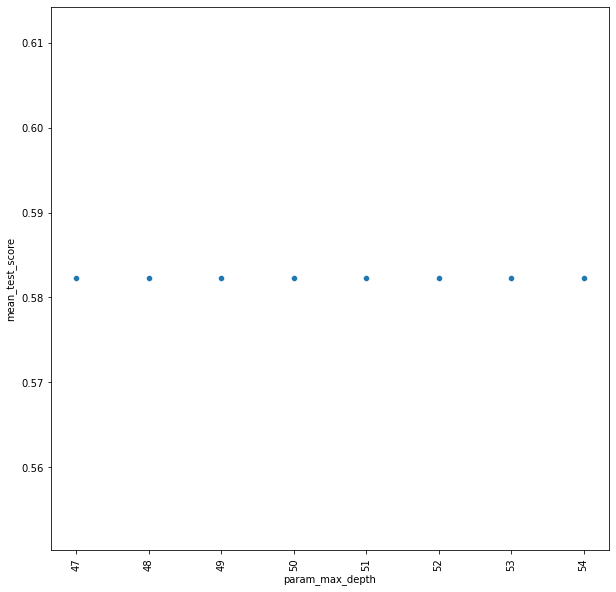

In [84]:
graph_max_depth_values(Gridclf_5.cv_results_, "param_max_depth", "mean_test_score")

#### Notes on Forrest attempt 4
Found better max depth value, however the mean_test_score is still lower than what it was for 11
- This can be see in the graph for attempt 3
-[Go to Attempt3](#forrest_3) if you wish to see this for yourself
    - 11 is over 0.65 in that graph,  while 47 is below 0.59 in the graph above

In [48]:
forrest_clf_4 = RandomForestClassifier(max_depth=47, n_estimators=500, class_weight='balanced_subsample', random_state=0)
forrest_clf_4.fit(train_split_attributes, train_split_target)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=47,
                       n_estimators=500, random_state=0)

In [87]:
print_eval_metrics(forrest_clf_4, ("Train", "Validate"), (train_split_attributes, train_split_target), (validate_split_attributes, validate_split_target))

Train f1 Score: 0.916
Train Precision Score: 0.894
Validate f1 Score: 0.591
Validate Precision Score: 0.599


[(0.9162805627310211, 0.8935327669053132),
 (0.5907369912614095, 0.5993083486025651)]

<a name="forrest_5"></a>
### Random Forrest Attempt 5
[To Table of Contents](#table_of_contents)

- My attempts so far have not made particularly accurate prediction algorithms
- Reducing the max depth hyperparameter to 11 did reduce the gap between the verification and training data significantly
    - However scores stayed in the range of 0.6 to 0.7 even upon increasing the estimations
- Since I have been unable to improve my algorithm using hyperparameter tuning of max depth (a form of pre-pruning), I will now attempt to use one of my overfit models (where max depth is 47 as it beat out 51 in attempt 4 above) and see if post-pruning can reduce the overfitting and improve prediction performance

In [28]:
ccp_alpha_clf = tree.DecisionTreeClassifier(class_weight='balanced')
path = ccp_alpha_clf.cost_complexity_pruning_path(validate_split_attributes, validate_split_target)

In [29]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [34]:
post_pruning_clf = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', random_state=0)

post_pruning_fridclf = GridSearchCV(post_pruning_clf, {"ccp_alpha": ccp_alphas}, scoring='f1_macro')

In [47]:
#post_pruning_fridclf.fit(validate_split_attributes, validate_split_target)

#### Notes on Forrest Attempt 5
- As you can see this attempt was not finished
- I wished to complete it however did not know how to select the values for ccp_alpha when using a random forrest
    - The subtree with the largest cost complexity that is smaller than ccp_alpha would have been chosen
    - I attempted to find it using GrisSearch, however I still was unsure how to select the range of values for GrisSearch to search through and attempt
- I have decided to keep this attempt here in hopes it manages to show something about my understanding, I knew of post-pruning however struggled to implement it myself

<a name="final_algorithm"></a>
# Choosing my Final Algorithm
[To Table of Contents](#table_of_contents)

Of all of my approaches, I achieved the best results from my random forrest with a max depth of 11
- You can get to that approach using this link -> [Go To Random Forrest 2](#forrest_2)

Out of every approach I attempted to solve this machine learning algorithm problem, this was the one which scored the best
- The gap bewteen Validation and Train score was the lowest for this algorithm
- Other algorithms had better Train scores, however they had a large difference between the Train and Validate signifying that I had overfit the algorithm to the train data

So given this, I will be using this algorithm to predict the outcomes of the test data

<a name="final_data_prep"></a>
## Data Preperation
[To Table of Contents](#table_of_contents)

In [142]:
test_data = pd.read_csv("test_data.csv")

In [143]:
test_data = prepare_data_for_algorithm(test_data, False)

In [144]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69177 entries, 0 to 69176
Data columns (total 38 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   APRSeverityOfIllnessCode                   69177 non-null  int64
 1   BirthWeight                                69177 non-null  int64
 2   AverageCostInCounty                        69177 non-null  int64
 3   AverageChargesInCounty                     69177 non-null  int64
 4   AverageCostInFacility                      69177 non-null  int64
 5   AverageChargesInFacility                   69177 non-null  int64
 6   AverageIncomeInZipCode                     69177 non-null  int64
 7   Gender_F                                   69177 non-null  uint8
 8   Gender_M                                   69177 non-null  uint8
 9   Gender_U                                   69177 non-null  uint8
 10  Race_Black/African American                691

In [146]:
# checking for missing values
pd.isna(test_data).sum()

APRSeverityOfIllnessCode                     0
BirthWeight                                  0
AverageCostInCounty                          0
AverageChargesInCounty                       0
AverageCostInFacility                        0
AverageChargesInFacility                     0
AverageIncomeInZipCode                       0
Gender_F                                     0
Gender_M                                     0
Gender_U                                     0
Race_Black/African American                  0
Race_Multi-racial                            0
Race_Other Race                              0
Race_White                                   0
TypeOfAdmission_Elective                     0
TypeOfAdmission_Emergency                    0
TypeOfAdmission_Newborn                      0
TypeOfAdmission_Trauma                       0
TypeOfAdmission_Urgent                       0
CCSProcedureCode_-1                          0
CCSProcedureCode_0                           0
CCSProcedureC

In [147]:
test_data.head()

,APRSeverityOfIllnessCode,BirthWeight,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,Gender_F,Gender_M,Gender_U,...,PaymentTypology_Federal/State/Local/VA,"PaymentTypology_Managed Care, Unspecified",PaymentTypology_Medicaid,PaymentTypology_Medicare,PaymentTypology_Miscellaneous/Other,PaymentTypology_Private Health Insurance,PaymentTypology_Self-Pay,PaymentTypology_Unknown,EmergencyDepartmentIndicator_N,EmergencyDepartmentIndicator_Y
0,3,4900,3242,8966,2448,13196,34,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,1,3100,2611,9227,1751,8951,45,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1,3300,3155,11381,1052,11314,74,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,1,3300,2611,9227,3790,6250,45,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,2,3800,3155,11381,3032,10135,59,1,0,0,...,0,0,1,0,0,0,0,0,1,0


<a name="final_prediction"></a>
## Predicting Test Data
[To Table of Contents](#table_of_contents)

In [148]:
# forrest_clf_3 is the classifier created in Random Forrest 2
final_clf = forrest_clf_3

In [171]:
predictions = final_clf.predict(test_data)

#### Note about predictions
- In my code I decided to treat a value of 1 as Class 0 and a value of 0 as Class 1
- Will need to invert to match what the assignment expects in output file

In [173]:
prediction_inverter = {
        0: 1,
        1: 0
    }
for i in range(len(predictions)):
    predictions[i] = prediction_inverter[predictions[i]]

In [178]:
ids = np.arange(1, len(predictions)+1, 1)

In [186]:
predictions_dataframe = pd.DataFrame(data={
    "ID": ids,
    "LengthOfStay": predictions
})

In [191]:
predictions_dataframe.to_csv("s3716853_predictions.csv", index=False)